# CA5 - Gotham Robberies

Nida Grønbekk

We want to investigate if it is possible to predict number of armed robberies in different parts of Gotham city and its surrounding areas.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import missingno as msno
from mlxtend.plotting import heatmap

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor

## The data

In [3]:
data = pd.read_pickle('train4.pkl')

data

,demo_0,demo_1,demo_2,demo_3,demo_4,demo_5,demo_6,demo_7,demo_8,demo_9,...,demo_115,demo_116,demo_117,demo_118,demo_119,demo_120,demo_121,demo_122,demo_123,target
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,...,6.5,1845.9,9.63,missing,missing,missing,missing,0.0,missing,8.20
1,20009,3.22,1.64,92.31,3.18,7.15,13.17,28.71,10.22,2.18,...,4.2,4728.0,0.00,missing,missing,missing,missing,0.0,missing,71.99
2,66049,2.63,26.41,72.45,0.76,0.72,17.79,29.84,18.19,14.33,...,51.2,1290.5,3.33,62,5585480,89.13,0,5.8,83166.8,159.32
3,11157,2.39,0.29,98.87,0.62,0.61,10.72,22.81,11.00,17.50,...,3.0,3726.5,0.90,missing,missing,missing,missing,0.0,missing,24.66
4,17192,2.69,0.58,97.40,1.07,0.76,14.30,30.82,14.81,9.56,...,6.8,2510.4,2.26,missing,missing,missing,missing,0.0,missing,35.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,72411,2.25,28.48,69.97,0.57,5.36,8.76,21.07,9.39,22.29,...,21.1,3435.7,3.53,70,14050209,96.85,10,12.6,182766.91,814.31
1085,34012,2.14,1.07,98.12,0.43,1.83,9.04,17.98,8.56,28.70,...,10.7,3173.9,0.65,missing,missing,missing,missing,0.0,missing,80.79
1086,12804,2.59,6.09,88.43,4.70,2.83,10.61,21.71,9.93,14.18,...,2.8,4511.0,11.91,missing,missing,missing,missing,0.0,missing,91.78
1087,51266,2.83,0.95,76.55,4.06,33.93,13.94,30.43,14.79,9.63,...,7.6,6759.8,1.75,missing,missing,missing,missing,0.0,missing,165.02


We can see that the values of several of the features are set to "missing". Let us make this nan, easier to get overview of missing values later on.

In [4]:
data.replace('missing', np.nan, inplace=True)
# this changes the dtype of columns with these instances to object, cast to numeric
# first find where 
objects=[]
for i in data.columns:
    if data.loc[:,i].dtype == object:
        objects.append(i)

# change to numeric
data[objects] = data[objects].apply(pd.to_numeric, errors='ignore')

In [5]:
# Get a dictionary of where and how many observations are missing
liste = data.isnull().sum()
list_of_features_missing = {}
for i, val in enumerate(liste):
    if val > 0:
        list_of_features_missing['demo_{}'.format(i)]=val
print(list_of_features_missing)

{'demo_25': 1, 'demo_98': 930, 'demo_99': 930, 'demo_100': 930, 'demo_101': 930, 'demo_102': 930, 'demo_103': 930, 'demo_104': 930, 'demo_105': 930, 'demo_106': 930, 'demo_107': 930, 'demo_108': 930, 'demo_109': 930, 'demo_110': 930, 'demo_111': 930, 'demo_112': 930, 'demo_113': 930, 'demo_114': 930, 'demo_118': 930, 'demo_119': 930, 'demo_120': 930, 'demo_121': 930, 'demo_123': 930}


In the dictionary above you see which indexes have missing values, and how many. We will have to deal with this before creating any models or evaluating performance. Let us take a closer look at the columns with missing values (except the first one who only misses one value):

In [6]:
data.iloc[:,[98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,118,119,120,121,123]]

,demo_98,demo_99,demo_100,demo_101,demo_102,demo_103,demo_104,demo_105,demo_106,demo_107,...,demo_110,demo_111,demo_112,demo_113,demo_114,demo_118,demo_119,demo_120,demo_121,demo_123
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,138.0,205.48,123.0,183.14,61164.0,91072.10,443.2,205.5,81.87,90.58,...,0.0,9.42,8.0,8.0,38.7,62.0,5585480.0,89.13,0.0,83166.80
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,254.0,330.41,246.0,320.00,169205.0,220104.09,666.2,330.4,86.48,74.46,...,0.0,16.91,32.0,14.0,42.7,70.0,14050209.0,96.85,10.0,182766.91
1085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems like the columns are missing values in the same rows. Check this by simply dropping rows with nan values in the dataframe.

In [7]:
df_dropped = data.dropna()
df_dropped.shape

(159, 125)

We now have 159 rows (=1089-930). They did miss values in the same rows. As a lot of the rows have missing values, we might consider fitting models on the dataframe where missing values are simply dropped. Imputing values in 930 rows based on values in only 159 rows might give weird results. Important to consider both scenarios.

We make sure to replace "missing" with nan in the test set as well.

In [8]:
# test data to use for kaggle uploads
test = pd.read_pickle('test4.pkl')
test = test.replace('missing',np.nan)

# maybe need to change dtypes to numeric for this dataset as well.
ob=[]
for i in test.columns:
    if test.loc[:,i].dtype == object:
        ob.append(i)

# change to numeric
test[ob] = test[ob].apply(pd.to_numeric, errors='ignore')


## Visualization

Let us perform some visualization to get an overview of the data. Our dataset has 124 features, which is a lot. Using the visualization techniques we usually do would be tiresome and not very explanatory of our data. We try a different approach. I chose to visualize on the dataframe where missing values were dropped as they all had missing values in the same rows.

### Plot raw data
We plot the data, that is, x-axis represents the features, each line represents the values of one observation for every feature.

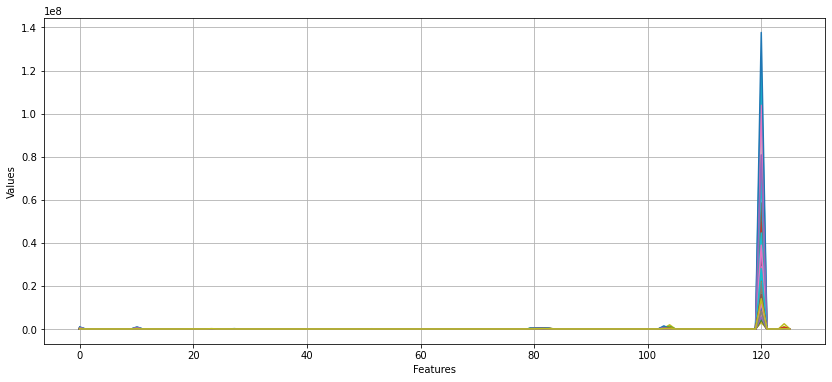

In [9]:
plt.figure(figsize=(14,6))
feature= np.linspace(0, 125, 125)
plt.plot(feature,df_dropped.T)
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid()
plt.show()

We can see that for most of the features they seem to have around the same ranges of values, this can bee seen by the almost flat line. However the feature at point 120 seems to have very large values compared to the other features, see this from the tall peak. This feature gives the strongest signal. We also see that the range between the lines at this feature is large, which tells us there is a high variance in this feature. Let us repeat the plot without this feature to get a better view of the other features.

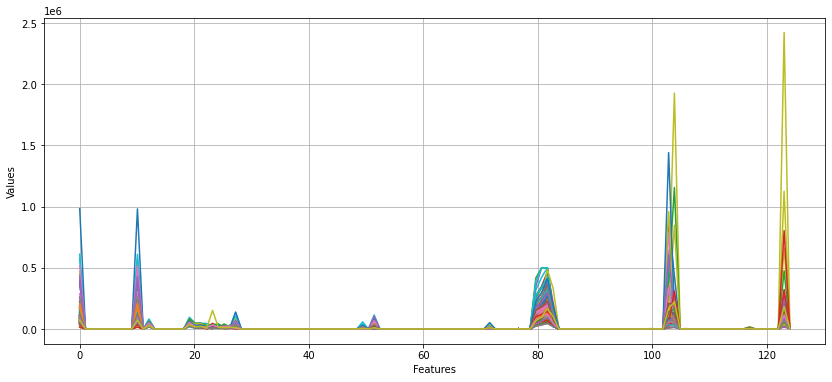

In [10]:
visual=df_dropped.loc[:, df_dropped.columns != 'demo_119']
plt.figure(figsize=(14,6))
feature= np.linspace(0, 124, 124)
plt.plot(feature,visual.T)
plt.xlabel('Features')
plt.ylabel('Values')
plt.grid()
plt.show()

Now we can see other features with a strong signal, at points around  0, 10, 80, 105 and 124. We see this from the peaks. More specific, at variables [demo_0,demo_10,demo_79,demo_80,demo_81,demo_82,demo_102,demo_103,demo_119,demo_123].

One can also see from the range between the lines at each of these feature points that the features demo_102, demo_103 and demo_123 has high variance. Also notice one single line in feature demo_123 reaching far up compared to the rest, this indicates an outlier.

### Missing data

We now consider the entire training and test dataset. Lets see where data is missing both in training and test set.

<AxesSubplot:>

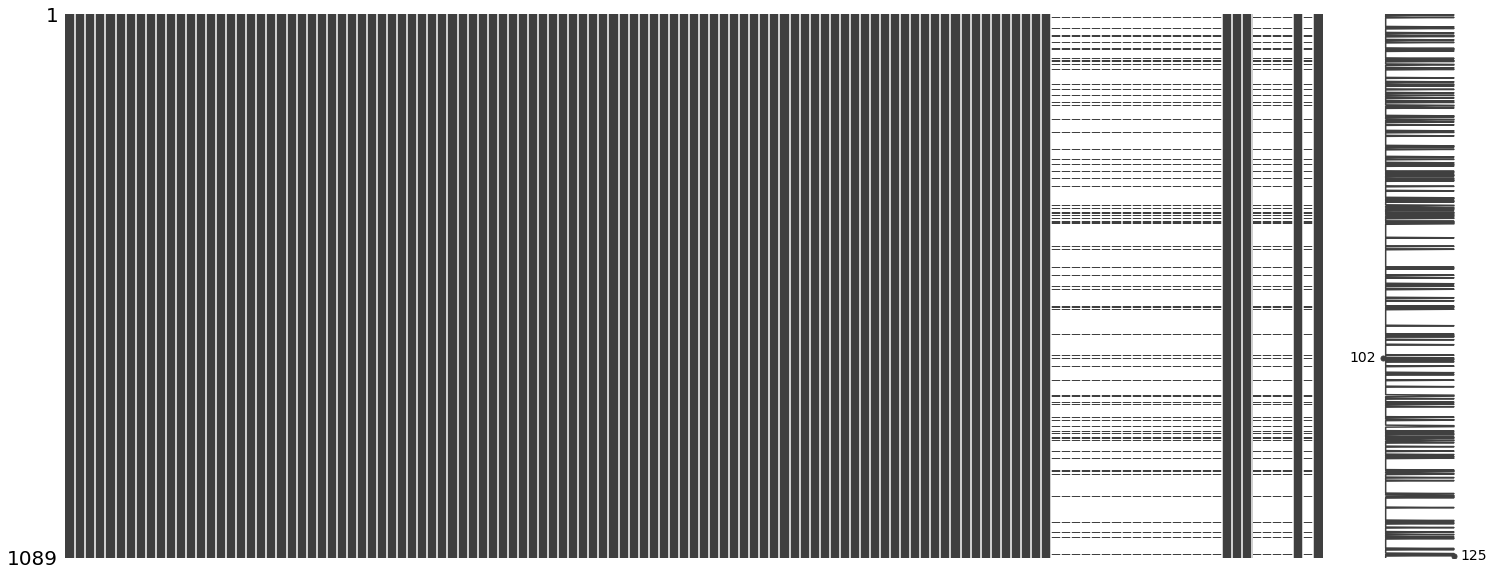

In [10]:
msno.matrix(data)

<AxesSubplot:>

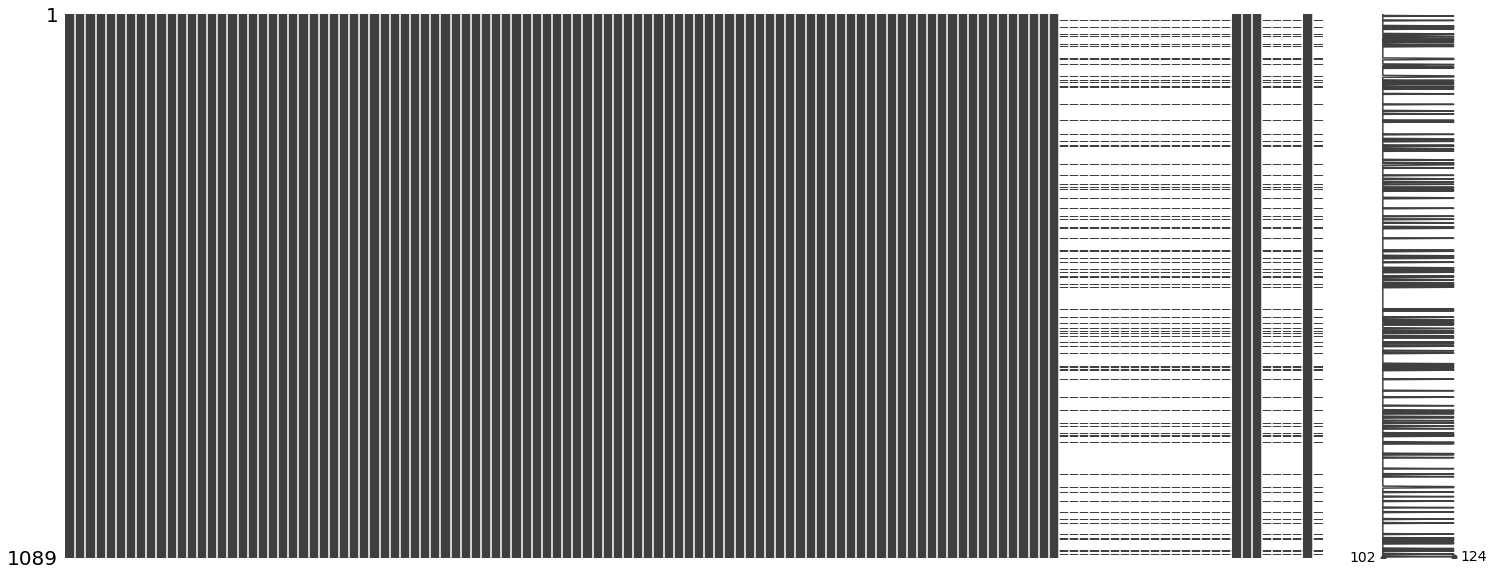

In [11]:
msno.matrix(test)

The matrix from the missingno package shows where data is missing, which is where the black line is not complete but have white spots. When comparing the training and test data it seems like the exact same features have the large amount of missing values, they are almost completely white. Because of this it could be reasonable to try to fit models on the dataset where we simply drop these features, as they are missing in both training and test data.

### Correlation matrix

Again, I chose to use the dataset where we drop rows with missing values for the visualization.

In [11]:
cols=df_dropped.columns
cm = np.corrcoef(df_dropped.values.T)

(fig,ax) = heatmap(cm,
            row_names=cols,
            column_names=cols,
                  figsize=(35,35))
bottom, top = ax.get_ylim()
plt.show()

KeyboardInterrupt: 

It is not very clear the exact correlation values as we have so many variables plotted against eachother, but we can see the color codes. We can see yellow/light-green squares several places in the figure, the variables here are highly correlated as they have values above 0.75. F.ex. demo_79,...,demo_87 against demo_19,...,demo_22. And demo_79,...,demo_87 against eachother. We also have a few points with dark blue color, high negative correlation, but not as much as we had of the positive high correlations. Outside of the yellow squares, it seems like most of the variables have less correlation, around 0.25 to -0.25. 

Also notice that the features were we had 930 missing values seems to not have high correlation with the target or other features, only a few have high correlation with other features in this group. Another reason for why simply dropping these features might be the best way to procede. 

## Our dataset

Based on the visualization I have decided to use the dataframe where we simply dropped the features with 930 missing values as they were missing as much in the test set as in the training set (and had low correlation with target). Replace the one missing value in demo_25 with the mean of the column. 

In [13]:
# Prepare our dataset for model training
liste = data.isnull().sum()
remove=[]
for i, val in enumerate(liste):
    if val > 1: # one feature only missing one value, keep this one
        remove.append('demo_{}'.format(i))

data = data.drop(remove,axis=1) # remove features
# we had one missing value in column demo_25, replace with mean of column
data=data.fillna(data.mean())

We have to remove these features from the test set as well.

In [14]:
# Prepare our dataset for model training
liste = test.isnull().sum()
remove=[]
for i, val in enumerate(liste):
    if val > 1: # one feature only missing one value, keep this one
        remove.append('demo_{}'.format(i))

# remove, if you print the list you see you get the same features as in the training set.
# Does indeed miss values in the same features.
test = test.drop(remove,axis=1)

## Pipeline with regression directly on pre-processed data

This pipeline applies a regression method directly on the pre-processed data. To choose between the models, I performed GridSearch with 10 fold cross-validation on the training dataset. I tried for the models:
- Linear regression (OLS, Ridge, LASSO, Elastic Net)
- RANSAC on the linear regression models
- Polynomial regression
- Decision tree regression
- Random Forest regression

After performing the Gridsearch on a separate training subset and predicting on the remaining observations as a test set I calculated the r2 scores. I got the best estimate for the LASSO model. This makes sense as the Lasso model reduces some of the weights to zero, removing the features. Our data has a lot of features and removing some of them would make a less complex model and better predictions. Note how a lot of the features did not have high correlation with the target value as seen in the correlation matrix. I include the code for performing GridSearch with the LASSO model:

In [15]:
# We split the training dataset in X and y
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
# Make training and test subsets to perform the GridSearch
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

pipe = make_pipeline(StandardScaler(),Lasso())
alpha = np.arange(0.5,3.1,0.1) # The range of alpha values we want to test
param_grid = {'lasso__alpha':alpha}
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='r2', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train,y_train)
y_pred = gs.predict(X_test)
# Estimate for r2 score on new data
print('r2 score:',r2_score(y_test,y_pred))

r2 score: 0.6786685622579214


We estimate the model to have an R^2 score of 0.679. 

In [16]:
print(gs.best_params_) # Get the best hyperparameters.

{'lasso__alpha': 2.9999999999999996}


The model got the best score estimate when using alpha approximately 3. We fit the model with the best hyperparameter on the entire training set and make predictions for the test set:

In [17]:
# Use the best estimator hyperparameters
reg = gs.best_estimator_
# Fit on entire training dataset.
reg.fit(X,y)
# Predict target for test dataset
predicted = reg.predict(test)
# dataframe of predictions
id_col=[i for i in range(0,test.shape[0])]
dict_val={'Id': id_col,'Predicted': predicted}
results=pd.DataFrame(dict_val)
results=results.set_index('Id')
# results.to_csv('results_01.csv')

The model got a score of 0.65650 when uploading to Kaggle.

## Pipeline with compression step and regression

In this pipeline we first perform compression of the dataset and then fit a regression model.

I consider the compression alternatives:
- Principal Component Analysis (PCA)
- KernelPCA
- Principal Least Squares (PLS)
- Feature Selection (SFS)

Note that PLS consits of both compression and least squares regression on the new compressed data.

I consider the mentioned compression alternatives in combination with the models mentioned in the previous section. I performed Gridsearch with 10 fold CV for each combination of model and compression step. Using a train subset of the original training set. Then estimated scores using the remaining as a test set. I got the best estimate when using backward sequential feature selection in combination with random forest. To select the features in SFS I used the linear regression model with LASSO regularization and alpha=3 as this model performed best on the pre-processed data in our previous pipeline. 

**Selecting the features:**

In [18]:
# Split in training and test set
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


lr = make_pipeline(StandardScaler(),Lasso(alpha=3))
#Start the sequential feature selector. It is backward selection (forward=False), removes one by 
# one until we are left with one feature(k_features=1). Use LASSO to choose features, and choose 
# the features based on r2 (scoring).
sfs = SFS(lr, 
           k_features=1, 
           forward=False, 
           floating=False, 
           verbose=0,
           scoring='r2',
           cv=10)
# Fit the models
sfs = sfs.fit(X_train, y_train)

# This dictionary contains results from all compuations
metricDict = sfs.get_metric_dict()

To find how many features gives the best average score:

In [19]:
ma=0 # store best avg_score
number_features=0 # store number of features that gives the best score
for num,dic in metricDict.items():
    if dic['avg_score']>ma:
        ma = dic['avg_score']
        number_features = num

print("We get the best average score: ",ma, " when including ",number_features," features.")

We get the best average score:  0.6961660948265187  when including  21  features.


You can see from the print that we get the best average score when using 21 features. We define our datasets to only include these features when fitting the model. The feature indexes that are to be included:

In [20]:
f = list(metricDict[21]['feature_idx'])
f

[2,
 5,
 9,
 11,
 22,
 23,
 27,
 29,
 38,
 44,
 45,
 46,
 49,
 50,
 73,
 77,
 90,
 92,
 93,
 99,
 101]

**Fitting the model:**

We now fit the model one the training set includeing the 21 most important features according to SFS.

In [21]:
sfs_X_train = X_train.iloc[:,f]
sfs_X_test = X_test.iloc[:,f]

d = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
pipe = RandomForestRegressor(random_state=1)

n_trees = [10,50,100,150]

param_grid={'max_depth': d,'n_estimators':n_trees}
gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='r2', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(sfs_X_train,y_train)

y_pred = gs.predict(sfs_X_test)

print('r2 score:',r2_score(y_test,y_pred))

r2 score: 0.7038797302476771


We got an R^2 estimate of 0.7039. 

In [22]:
print(gs.best_params_) # get the best hyperparameters

{'max_depth': 9, 'n_estimators': 150}


The best estimate of the R^2 score is achieved when we use 150 trees with max_depth 9. Fit the model with the best hyperparameters on the entire training set and then predict target values for the test set.

In [23]:
reg = gs.best_estimator_
# only include 21 features
sfs_X = X.iloc[:,f]
sfs_test = test.iloc[:,f]
reg.fit(sfs_X,y)
predicted = reg.predict(sfs_test)
# # dataframe of predictions
id_col=[i for i in range(0,sfs_test.shape[0])]
dict_val={'Id': id_col,'Predicted': predicted}
results=pd.DataFrame(dict_val)
results=results.set_index('Id')
#results.to_csv('results_02.csv')

The model got a score of 0.67997 when uploading to kaggle.

## Summary

We got the best performance metric when selecting features based on backward SFS using Lasso with alpha=3, and fitting a Random Forest model (with max_depth=9 and n_estimators=150) on these selected features. The best score was **0.67997**.

## Difference from analyzing tall data

Our dataset had the problem of having high dimensionality (many features). We also saw from the correlation matrix that a lot of them had low correlation with the target, an indication of them not being that important in predictions. When we are dealing with this type of dataset, compression becomes very important. 

The best model for the pipeline with regression directly on pre-processed data was the LASSO model. Due to some weights getting a value of zero, the model ignores/removes certain features. It makes sense that this model performed best as our dataset has many features with low correlation. Also from the other pipeline we got best performance when reducing number of features. When working with tall data these methods would often give bad models as seen in previous compulsary assignments. As they have few features, dropping them makes models perform worse as they have less information to use when creating the models. In those cases feature space transformations (such as PCA) would give a better result, not feature selection.